# Import

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Spelling correction
import textblob
from textblob import TextBlob

# Text manipulation
import regex as re

# Lemmatization and tokenization
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Spacy
#import spacy
#nlp=spacy.load('en_core_web_sm')

# Creating vecotorization
from collections import Counter

# Inflect
import inflect
inflect = inflect.engine()

# Sentiment analysis with vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Wordcloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS

# Topic modeling
import gensim

# Loughran-McDonald sentiment word lists
from sklearn.feature_extraction.text import CountVectorizer

# Handling datetime
from pandas import to_datetime

# Plotting
import seaborn as sns

# multiprocessing
from joblib import Parallel, delayed

# wordcloud
from PIL import Image
!pip install wordcloud
from wordcloud import WordCloud

# import libraries from main preprocessing function file
from NLP_Preprocessing_Functions import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('./Data/news_data.csv', sep =";")
df.head(2).style

,URL,datetime,heading,text,newssite
0,https://www.scmp.com/news/hong-kong/society/article/3199619/no-horseplay-new-riding-simulator-therapy-hong-kong-offers-disabled-entry-sport,2022-11-16 02:00:00+00:00,No horseplay: new riding simulator therapy in Hong Kong offers disabled entry into sport,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence",South China Morning Post
1,https://www.scmp.com/news/hong-kong/transport/article/3199750/hong-kongs-mtr-corporation-testing-new-trains-retrofitted-old-signalling-system-bid-replace-ageing,2022-11-16 00:00:00+00:00,Hong Kong's MTR Corporation testing new trains retrofitted with old signalling system in bid to replace ageing model on 4 lines,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,South China Morning Post


In [3]:
# Delete rows with missing datetime
df = df.dropna()

# Convert column datetime to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
df['year'] = df['datetime'].dt.year.astype('category')
df['weekday']=df['datetime'].dt.weekday.astype('category')
df['month'] = df['datetime'].dt.month.astype('category')
df['date'] = df['datetime'].dt.date.astype('category')


# Data preparation

## 1.1. Demonstration of Steps 

NOTE Skip these steps and go to point 1.2 if you want to do all steps at once and faster (in a paralell way)

## 1.1.1. Spelling correction

In [5]:
df['processed_text'] = df['text'].apply(lambda x: correct_spelling(x))

In [6]:
df.iloc[:3,:][['text', 'processed_text']].style

,text,processed_text
0,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence","Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence"
1,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,Insider reveals operator has not ruled out train defects as a cause of Sunday is derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned
2,"The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say","The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say"


## 1.1.2. Remove special characters

In [7]:
df['processed_text'] = df['processed_text'].apply(lambda x: remove_special_characters_and_parts(x))

In [8]:
df.iloc[:3,:][['text', 'processed_text']].style

,text,processed_text
0,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence",Leong Pui yee who has cerebral palsy shares benefits of horse riding as long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus association hopes to bring new simulator programme to more people to help them with fitness and confidence
1,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,Insider reveals operator has not ruled out train defects as cause of Sunday is derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned
2,"The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say",The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of comprehensive regulatory framework experts say


## 1.1.3 Tokenization and Lemmatization

In [9]:
df['processed_text'] = df['processed_text'].apply(lambda x: normalize_text(x))

In [10]:
df.iloc[:3,:][['text', 'processed_text']].style

,text,processed_text
0,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence",leong pui yee have cerebral palsy share benefit horse riding as long time participant riding disabled association activities partnership operation santa claus association hope to bring new simulator programme more people to help fitnesses and confidence
1,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,insider reveal operator have not rule train defect as cause sunday is derailment yau ma tei station mtr spokeswoman confirm 93 new train are being retrofitted existing signalling system so can commence service as planned
2,"The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say",rapid rise and fall ftx appear to have vindicate cautious approach take hong kong government crypto market collapse have likely make participant crypto industry more accepting comprehensive regulatory framework expert say


## 1.1.4. Remove stopwords

"I decided to go here for a list that does not remove much words the standard NLTK or Spacy stop word list
Spacys or NLTK Stopword list for example would remove words that are actually important - as I found out later.
And therefore would rahter lead to more issues instead of giving meaningful help"

In [11]:
df['processed_text'] = df['processed_text'].apply(lambda x: remove_stop_words(x))

In [13]:
df.iloc[:3,:][['text', 'processed_text']].style

,text,processed_text
0,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence",leong pui yee cerebral palsy share benefit horse riding time participant riding disabled association activities partnership operation santa claus association hope bring simulator programme people fitnesses confidence
1,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,insider reveal operator rule train defect sunday derailment yau tei station mtr spokeswoman confirm 93 train retrofitted existing signalling commence service planned
2,"The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say",rapid rise fall ftx vindicate cautious approach hong kong government crypto market collapse participant crypto industry accepting comprehensive regulatory framework expert


## 1.2. Apply All Preprocessing Steps with Multiprocessing

In [4]:
# defining a wrapper function
def do_preprocessing(text):
    text = correct_spelling(text)
    text = remove_special_characters_and_parts(text)
    text = normalize_text(text)
    text = remove_stop_words(text)
    return text    

In [5]:
df['processed_text'] = Parallel(n_jobs=4)(delayed(do_preprocessing)(i) for i in df['text'].to_list())

In [6]:
df.iloc[:3,:][['text', 'processed_text']].style

,text,processed_text
0,"Leong Pui yee, who has cerebral palsy, shares benefits of horse riding as a long time participant in Riding for the Disabled Association activities In partnership with Operation Santa Claus, association hopes to bring new simulator programme to more people to help them with fitness and confidence",leong pui yee cerebral palsy share benefit horse riding time participant riding disabled association activities partnership operation santa claus association hope bring simulator programme people fitnesses confidence
1,Insider reveals operator has not ruled out train defects as a cause of Sunday's derailment at Yau Ma Tei station MTR spokeswoman confirms 93 new trains are being retrofitted with existing signalling system so they can commence service as planned,insider reveal operator rule train defect derailment yau tei station mtr spokeswoman confirm train retrofitted existing signalling commence service planned
2,"The rapid rise and fall of FTX appears to have vindicated the cautious approach taken by the Hong Kong government in the crypto market That collapse has likely made participants in the crypto industry more accepting of a comprehensive regulatory framework, experts say",rapid rise fall ftx vindicate cautious approach government crypto market collapse participant crypto industry accepting comprehensive regulatory framework expert


#### Save results

In [7]:
df.to_pickle('./data/Preprocessed_news_data') 

In [8]:
df = pd.read_pickle('./data/Preprocessed_news_data')

### Data Enrichment

#### Named Entity Recognition for COVID

In [9]:
%%capture
keyterms = ["covid", "corona", "covid-19", "pandemic"]

index = 0
df["total_articles_about_covid"] = None
for text in df.iterrows():
    text = df.iloc[index]["processed_text"]
    for i in text.split(" "):
        if i in keyterms:
            df["total_articles_about_covid"].iloc[index] = 1
    
    index += 1

#### Sentiment Analysis

In [10]:
negative_terms = ["accident", "death", "die", "ban", "desaster", "arrest"]

def sentiment_analsis(text):
    """
    The following function can be used to indicate weather a
    newsarticle should be considered as positive or negative.
    It uses as basis the sentiment polarity from the library textblob
    and it extends it with a custom approach, to get more realistic results. 
    """
    text_blob_sentiment = TextBlob(text).sentiment.polarity
    for i in text.split(" "):
        if i in negative_terms:
            text_blob_sentiment -= 0.2
    if text_blob_sentiment < 0:
        return True
    else:
        return False

In [11]:
%%capture
index = 0
df["total_negative_articles"] = None
for text in df.iterrows():
    text = df.iloc[index]["processed_text"]
    if sentiment_analsis(text):
        df["total_negative_articles"].iloc[index] = 1
    
    index += 1

## Data Aggregation

#### News Data 

In [12]:
import datetime
# select correct time range
df = df[df["datetime"].dt.date >= datetime.date(2022, 11, 2)]
#aggregate
grouped_df = df.groupby([df['datetime'].dt.date]).count()

#remove unnecessary columns
grouped_df.drop(columns = ["heading", "datetime", "text", "newssite", "year", "weekday", "month", "date", "processed_text"], inplace=True)

#create additional columns
grouped_df = grouped_df.rename(columns={"URL": "total_number_of_articles"})
grouped_df["ratio_articles_about_covid"] = grouped_df["total_articles_about_covid"] / grouped_df["total_number_of_articles"] 
grouped_df["ratio_negative_articles"] = grouped_df["total_negative_articles"] / grouped_df["total_number_of_articles"] 
grouped_df

,total_number_of_articles,total_articles_about_covid,total_negative_articles,ratio_articles_about_covid,ratio_negative_articles
datetime,,,,,
2022-11-02,4,3,3,0.750000,0.750000
2022-11-03,12,6,5,0.500000,0.416667
2022-11-04,11,6,4,0.545455,0.363636
2022-11-05,8,6,3,0.750000,0.375000
2022-11-06,7,6,2,0.857143,0.285714
2022-11-07,10,6,3,0.600000,0.300000
2022-11-08,13,5,7,0.384615,0.538462
2022-11-09,37,10,20,0.270270,0.540541
2022-11-10,19,8,14,0.421053,0.736842


In [13]:
#load file
df_index = pd.read_csv('./data/index_data.csv', sep = ";")
df_index.rename(columns = {"Datetime":"datetime"}, inplace=True)
# correct file format
df_index['datetime']= pd.to_datetime(df_index['datetime'])
df_index['Index Value']= df_index['Index Value'].str.replace(",","").astype(float)
# select correct time range
df_index = df_index[df_index["datetime"].dt.date >= datetime.date(2022, 11, 2)]
#ggregate data
df_index = df_index.groupby([df_index['datetime'].dt.date]).mean()

In [14]:
df_index

,Index Value
datetime,
2022-11-02,15827.170000
2022-11-03,15404.774286
2022-11-04,16065.981000
2022-11-05,16161.140000
2022-11-06,16161.140000
2022-11-07,16549.728500
2022-11-08,16552.625625
2022-11-09,16389.200000
2022-11-10,16093.953684


In [15]:
#load file
df_weather = pd.read_csv('./data/weather_data.csv', sep = ";")
df_weather.rename(columns = {"time":"datetime"}, inplace=True)
# correct file format
df_weather['datetime']= pd.to_datetime(df_weather['datetime'])
# select correct time range
df_weather = df_weather[df_weather["datetime"].dt.date >= datetime.date(2022, 11, 2)]
#ggregate data
df_weather = df_weather.groupby([df_weather['datetime'].dt.date]).mean()

In [16]:
df_weather

,Wind in km/h,Humidity in %,Precipitation in mm,Visibility in km,UV index
datetime,,,,,
2022-11-02,34.400000,88.550000,1.450000,9.016000,1.000000
2022-11-03,14.238095,90.380952,0.619048,9.200000,1.190476
2022-11-04,18.650000,83.650000,0.000000,9.660000,1.550000
2022-11-05,13.782609,79.304348,0.173913,9.023043,1.347826
2022-11-06,12.045455,84.000000,0.318182,8.708636,1.681818
2022-11-07,12.200000,82.700000,0.100000,9.338000,1.800000
2022-11-08,11.187500,82.375000,0.000000,9.559375,1.812500
2022-11-09,10.909091,79.545455,0.000000,9.586818,1.590909
2022-11-10,10.473684,78.842105,0.000000,9.236316,1.368421


Humidity, Visibility and UV index seem rather less interesting as they rarely change.
Hence we are dropping them.

In [17]:
df_weather = df_weather.drop(columns = ["Humidity in %", "Visibility in km", "UV index"])

#### Merging all datasets

In [18]:
final_df = pd.concat([pd.concat([grouped_df, df_weather], axis=1), df_index], axis = 1)

In [19]:
final_df.to_csv("./data/preprocessed_and_merged_datasets.csv", sep =";")

### Visual Analysis

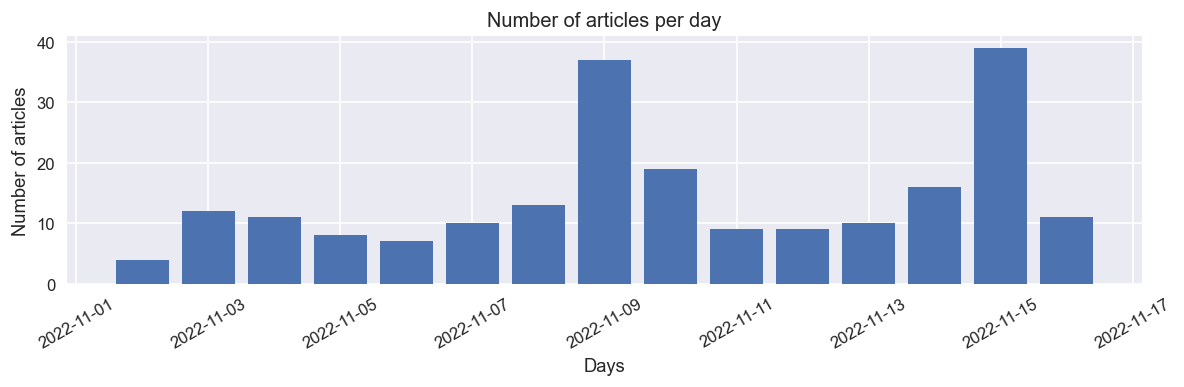

In [22]:
plt.figure(figsize=(10,3), dpi =120)
plt.style.use("seaborn")
plt.bar(x = final_df.index, height = final_df["total_number_of_articles"])
plt.title("Number of articles per day")
plt.xlabel("Days")
plt.ylabel("Number of articles")
plt.tight_layout()
_ = plt.xticks(rotation=30)
plt.savefig("./data/images/Analysis_Plots_Total_Number_Of_Articles")

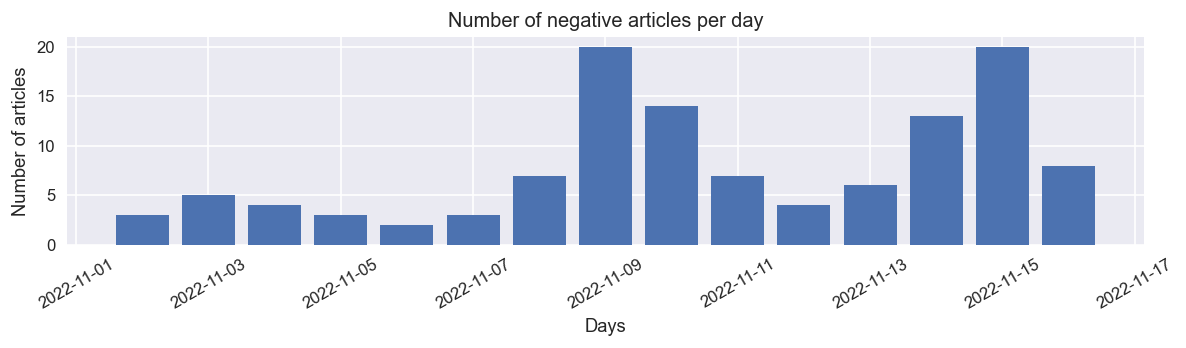

In [23]:
plt.figure(figsize=(10,3), dpi =120)
plt.style.use("seaborn")
plt.bar(x = final_df.index, height = final_df["total_negative_articles"])
plt.title("Number of negative articles per day")
plt.xlabel("Days")
plt.ylabel("Number of articles")
_ = plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("./data/images/Analysis_Plots_Total_Number_Of_Negative_Articles")


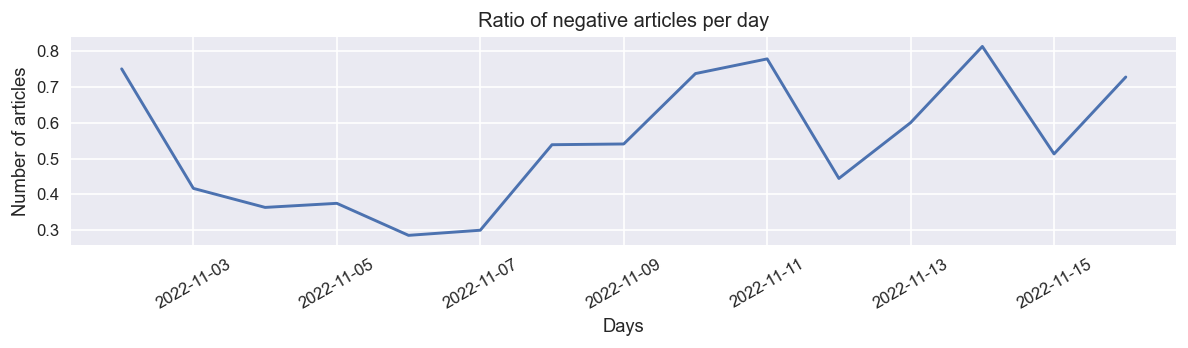

In [24]:
plt.figure(figsize=(10,3), dpi =120)
plt.style.use("seaborn")
plt.plot(final_df.index, final_df["ratio_negative_articles"])
plt.title("Ratio of negative articles per day")
plt.xlabel("Days")
plt.ylabel("Number of articles")
_ = plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("./data/images/Analysis_Plots_Ratio_Of_Negative_Articles")


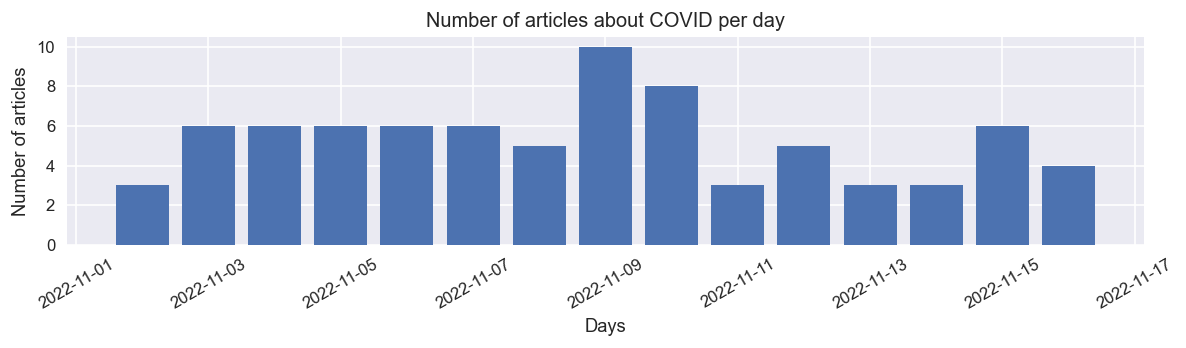

In [25]:
plt.figure(figsize=(10,3), dpi =120)
plt.style.use("seaborn")
plt.bar(x = final_df.index, height = final_df["total_articles_about_covid"])
plt.title("Number of articles about COVID per day")
plt.xlabel("Days")
plt.ylabel("Number of articles")
_ = plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("./data/images/Analysis_Plots_Total_Number_Of_COVID_Articles")


In [25]:
df['type'] =  np.where(df['total_negative_articles'] == 1, 'negative', 'positive')

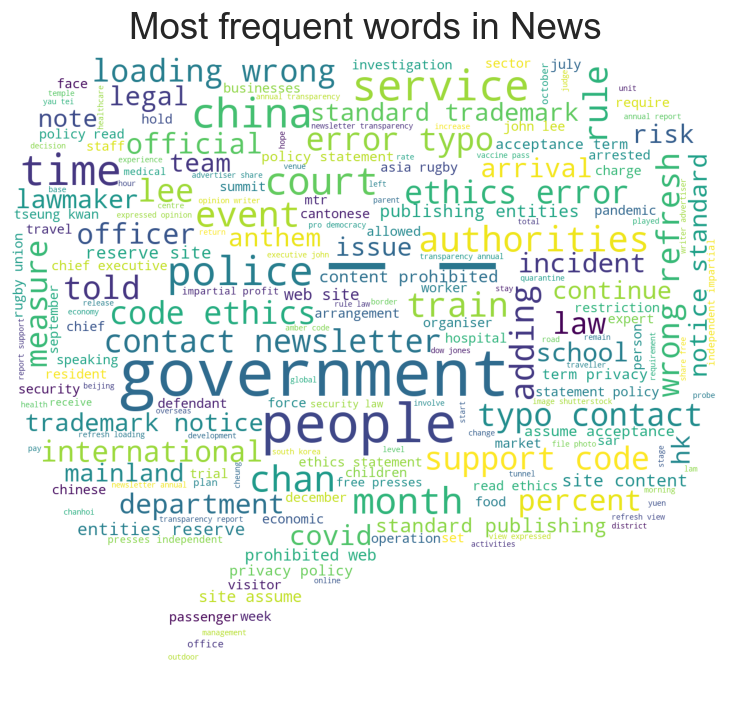

In [27]:

sms_picture = np.array(Image.open('./data/images/speech-bubble.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=sms_picture,
)

plt.figure(figsize=(9,7), dpi =120)
wc.generate(' '.join(text for text in df['processed_text']))
plt.title('Most frequent words in News', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.savefig("./data/images/Analysis_Plot_Frequent_Words")
plt.show()

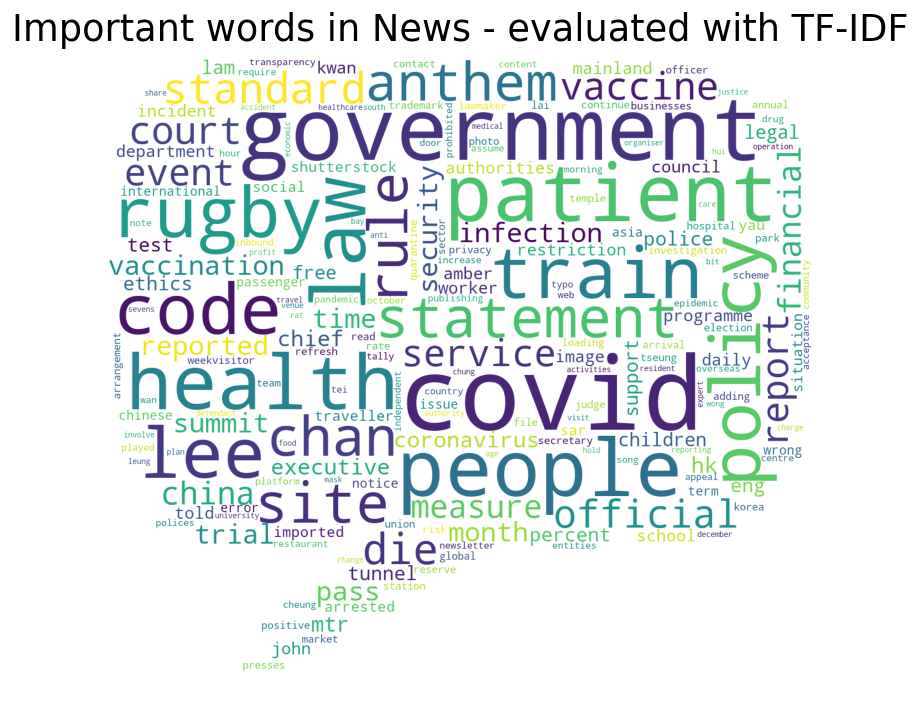

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(df['processed_text'])

features = vectorizer.get_feature_names()
tdidf_df = pd.DataFrame(vecs.todense().tolist(), columns=features)

wc =WordCloud(background_color='white', 
                max_words=200, 
                mask=sms_picture).generate_from_frequencies(tdidf_df.T.sum(axis=1))

plt.figure(figsize=(9,7), dpi =120)
plt.title('Important words in News - evaluated with TF-IDF', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.tight_layout()
plt.savefig("./data/images/Analysis_Plot_TFIDF_Important_Words")
plt.show()

In [30]:
tdidf_df.T.sum(axis=1)

aapl            0.043824
abandoned       0.814084
abbreviation    0.023445
abducted        0.089971
aberdeen        0.250956
                  ...   
zhuhai          0.352357
zip             0.121958
zone            0.189727
zsuzsanna       0.302714
zurich          0.075478
Length: 5350, dtype: float64

# Sentiment Analysis  Experimentation

Was done to choose the explore the libraries offering sentiment analysis to then decide for one method.

## Sentiment Analysis using TextBlob

TextBlob is a relatively simple approach to do sentiment analysis in Python.

The approach works mainly by looking at the single words used in a text, without taking the context into considerating. For all single words the alorithmn then decides if they are neutral, positive or negative. Depending on the number of "positive" and "negative" words used the text then gets a sentiment score.

In [30]:
def polarity_TextBlob(text):
    return TextBlob(text).sentiment.polarity

df['polarity_score_TextBlob']=df['processed_text'].apply(lambda x : polarity_TextBlob(x))

In [31]:
def sentiment_results(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'
    
df['polarity_TextBlob']=df['polarity_score_TextBlob'].map(lambda x: sentiment_results(x))

### Problems with sentiment Analysis

As the approach of textblob is relatively simple it also comes with a number of drawbacks

#### Negative Words Used in Positve Context

In [32]:
TextBlob("Hong Kong police anti scam site saves public at least HK$400 million in fraud losses since September launch, police say").sentiment.polarity

-0.15

#### Negative Words do not get regonized

In [33]:
TextBlob("Man dies after falling into manhole to fetch wallet").sentiment.polarity

0.0

#### Non relevant words for the sentiment outweigh relevant words

In [34]:
TextBlob("People are feeling terribly bad. John was walking fast. The sun was shining, the weather was good. ").sentiment.polarity

0.06666666666666671

## Sentiment analysis using VADER

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
works better in detecting negative sentiment

In [35]:
sid = SentimentIntensityAnalyzer()

def polarity_vader(text):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(text)
    return np.argmax(list(ss.values())[:-1])
df['polarity_score_vader'] = df['processed_text'].map(lambda x: polarity_vader(x))
df['polarity_vader']=df['polarity_score_vader'].replace({0:'negative',1:'neutral',2:'positive'})

In [36]:
df.head(3)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,total_articles_about_covid,total_negative_articles,polarity_score_TextBlob,polarity_TextBlob,polarity_score_vader,polarity_vader
0,https://www.scmp.com/news/hong-kong/society/ar...,2022-11-16 02:00:00+00:00,No horseplay: new riding simulator therapy in...,"Leong Pui yee, who has cerebral palsy, shares...",South China Morning Post,2022,2,11,2022-11-16,leong pui yee cerebral palsy share benefit hor...,None,1,-0.2,negative,1,neutral
1,https://www.scmp.com/news/hong-kong/transport/...,2022-11-16 00:00:00+00:00,Hong Kong's MTR Corporation testing new train...,Insider reveals operator has not ruled out tr...,South China Morning Post,2022,2,11,2022-11-16,insider reveal operator rule train defect sund...,None,None,0.0,neutral,1,neutral
2,https://www.scmp.com/tech/tech-trends/article/...,2022-11-15 23:00:00+00:00,Hong Kong may benefit from FTX collapse as in...,The rapid rise and fall of FTX appears to hav...,South China Morning Post,2022,1,11,2022-11-15,rapid rise fall ftx vindicate cautious approac...,None,None,0.0,neutral,1,neutral


## Sentiment analysis using Loughran-McDonald sentiment word lists

Wordlist specifically built for textual analysis related finance (https://sraf.nd.edu/loughranmcdonald-master-dictionary/)

In [126]:
# source: https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92#:~:text=Machine%20learning%20models%20implemented%20in,forms%20to%20forecast%20stock%20movements
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining']

sentiment_df = pd.read_csv('./Data/Loughran-McDonald_MasterDictionary_1993-2021.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

def lemmatize_words(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    return lemmatized_words

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,word
9,True,False,False,False,False,abandon
12,True,False,False,False,False,abandonment
13,True,False,False,False,False,abandonments
51,True,False,False,False,False,abdicate
54,True,False,False,False,False,abdication


#### Jaccard Similarity

Count how many negative/positive/.... words occur in the document and jaccard similarity to determine how similar the bag of words in the newspaper and the bag of words of the respecitive sentiment are.

In [127]:
def count_sentiments(sent_words_filtered, text_list):
    vec = CountVectorizer(vocabulary=sent_words_filtered)
    vectors = vec.fit_transform(text_list)
    sentiment_counts = np.zeros([len(text_list), len(vec.get_feature_names_out())])
    
    for i in range(len(text_list)):
        sentiment_counts[i] = vectors[i].toarray()[0]

    sum_word = sentiment_counts.astype(int).sum(axis=1)
      
    # Calculate jaccard similarity
    jac_sim = np.zeros([len(text_list)])
    for i in range(len(text_list)):
        jac_sim[i] = float(sum_word[i]) / ((len(sent_words_filtered) + len(text_list[i].split())) - float(sum_word[i]) )

    return jac_sim, sum_word


for sentiment in sentiments:
    df[sentiment + '_jacsim'], df[sentiment + '_count'] = count_sentiments(sentiment_df.loc[sentiment_df[sentiment] == True]['word'], df['processed_text'].tolist() )

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [20]:
df.head(6)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,...,negative_jacsim,negative_count,positive_jacsim,positive_count,uncertainty_jacsim,uncertainty_count,litigious_jacsim,litigious_count,constraining_jacsim,constraining_count
0,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 12:00:00+00:00,First stage of ban Hong Kong ban on single us...,Plan changed because of increased acceptance ...,South China Morning Post,2022,1,10,2022-10-18,plan change because increase acceptance non ...,...,0.000000,0,0.00000,0,0.0,0,0.000000,0,0.0,0
1,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 09:08:00+00:00,Coronavirus: legal aid granted to ex civil se...,High profile serial litigant Kwok Cheuk kin w...,South China Morning Post,2022,1,10,2022-10-18,high profile serial litigant kwok cheuk kin ...,...,0.001942,3,0.00722,2,0.0,0,0.006729,5,0.0,0
2,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-10-18 06:58:00+00:00,Hong Kong customs finds crystal meth hidden i...,Consignment containing 76kg of meth was in tr...,South China Morning Post,2022,1,10,2022-10-18,consignment containing 76 kg meth was transi...,...,0.000000,0,0.00000,0,0.0,0,0.000000,0,0.0,0
3,https://www.scmp.com/news/hong-kong/politics/a...,2022-10-18 05:59:00+00:00,Hong Kong will need more time on Article 23 r...,The local legislation cannot be rushed as it ...,South China Morning Post,2022,1,10,2022-10-18,local legislation not rushed as have cover s...,...,0.000000,0,0.00000,0,0.0,0,0.001335,1,0.0,0
4,https://www.scmp.com/news/hong-kong/health-env...,2022-10-18 04:25:00+00:00,Coronavirus: Hong Kong 'set to ease cap on pu...,Sources say top advisers approved move at Tue...,South China Morning Post,2022,1,10,2022-10-18,source say top adviser approve move tuesday ...,...,0.000647,1,0.00000,0,0.0,0,0.000000,0,0.0,0
6,https://www.scmp.com/news/hong-kong/hong-kong-...,2022-09-11 03:00:00+00:00,Hong Kong has extended its Covid 19 vaccine p...,New scheme comes into force on Friday with fi...,South China Morning Post,2022,6,9,2022-09-11,new scheme come force friday first phase req...,...,0.000647,1,0.00000,0,0.0,0,0.000000,0,0.0,0


# Named entity recognition

In [169]:
def extract_company(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_=='ORG' else None
df['company']=df['processed_text'].apply(lambda x : extract_company(x))

def extract_country(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'GPE' else None
df['country']=df['processed_text'].apply(lambda x : extract_country(x))

def extract_date(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'DATE' else None        
df['date_event']=df['processed_text'].apply(lambda x : extract_date(x))

def extract_event(text):
    doc=nlp(text) 
    for x in doc.ents:
        return x.text if x.label_ == 'EVENT' else None   
       
df['event']=df['processed_text'].apply(lambda x : extract_event(x))


In [170]:
df.head(6)

,URL,datetime,heading,text,newssite,year,weekday,month,date,processed_text,total_articles_about_covid,total_negative_articles,company,country,date_event,event
0,https://www.scmp.com/news/hong-kong/society/ar...,2022-11-10 02:00:00+00:00,Operation Santa Claus: Hong Kong charity teac...,Organisation aims to popularise sign language...,South China Morning Post,2022,3,11,2022-11-10,organisation aim popularise sign language pr...,None,None,santa claus project enable,None,None,None
1,https://www.scmp.com/news/hong-kong/society/ar...,2022-11-10 01:00:00+00:00,Hong Kong worksite deaths: harsher penalties ...,"Unionists want the law changed soon, but cons...",South China Morning Post,2022,3,11,2022-11-10,unionist want law change soon construction s...,None,1,None,None,None,None
2,https://www.scmp.com/news/hong-kong/health-env...,2022-11-09 23:00:00+00:00,Healthcare start ups eye potential investors ...,About 180 local and overseas healthcare start...,South China Morning Post,2022,2,11,2022-11-09,180 local overseas healthcare start up showc...,None,None,None,None,None,None
3,https://www.scmp.com/news/hong-kong/society/ar...,2022-11-09 15:58:00+00:00,'I'm in it to win it': Hong Kongs florists op...,"Bidding for 175 wet goods stalls begins, with...",South China Morning Post,2022,2,11,2022-11-09,bidding 175 wet good stall begin three four ...,None,None,None,None,None,None
4,https://www.scmp.com/news/hong-kong/hong-kong-...,2022-11-09 15:46:00+00:00,Hong Kong signs deal to increase investment i...,Hong Kong to invest more in Zhuhai airport an...,South China Morning Post,2022,2,11,2022-11-09,hong kong invest more zhuhai airport create ...,None,None,None,hong kong,None,None
5,https://www.scmp.com/news/hong-kong/law-and-cr...,2022-11-09 13:08:00+00:00,Hong Kong police anti scam site saves public ...,"Police say 4,350 red flags raised among 74,00...",South China Morning Post,2022,2,11,2022-11-09,police say 4 350 red flag raise 74 000 inqui...,None,None,None,None,None,None


In [23]:
df['company'].unique()

array([None, 'cathay', 'congress', 'intensifie', 'hui', 'kin',
       'warner cheuk', 'eastern court magistrate', 'cnn'], dtype=object)

In [24]:
df['date_event'].unique()

array([None, 'tuesday', 'next month', 'early fourth quarter 2023',
       'monday', 'sunday', 'saturday', 'end year', '63 year old',
       'thursday', 'wednesday 4 420', 'wednesday', '61 year old',
       '87 year old', '26 year old', 'fourth quarter 2024'], dtype=object)

In [25]:
df['country'].unique()

array([None, 'hong kong', 'singapore', 'hong kong council', 'japan',
       'taiwan'], dtype=object)

# Create Wordcloud

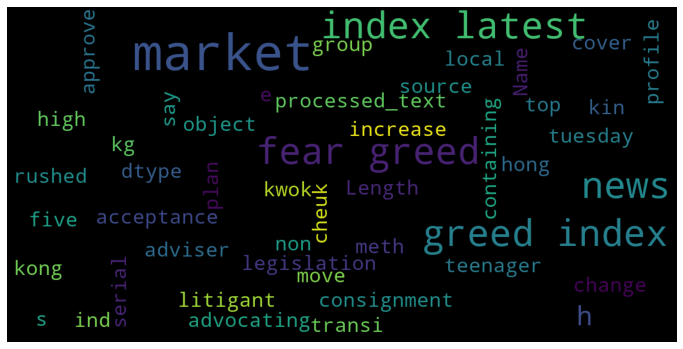

In [26]:
# source: https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/4-0-wordclouds-853dfded-4d17-4f37-83e4-15ec53f74e60/5833b046-3cf9-4c0f-8fbf-4a5933da924e

def plot_wordcloud(text):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=30, 
        scale=3,
        random_state=1).generate(text)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

    
plot_wordcloud(str(df['processed_text']))

# Topic modeling exploration with pyLDAvis

In [27]:
# Prepare data for applying the model (create corpus)
# sources: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
#+ https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.processed_text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])


['plan', 'change', 'because', 'increase', 'acceptance', 'non', 'plastic', 'alternative', 'disposable', 'item', 'cutlery', 'straw', 'plate', 'sale', 'free', 'distribution', 'other', 'plastic', 'hotel', 'toiletries', 'umbrella', 'cover', 'toothbrushes', 'banned']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


In [28]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"have" + 0.008*"hong" + 0.008*"said" + 0.008*"kong" + 0.006*"that" + '
  '0.006*"not" + 0.005*"were" + 0.005*"covid" + 0.005*"new" + 0.005*"was"'),
 (1,
  '0.012*"have" + 0.012*"hong" + 0.010*"was" + 0.009*"kong" + 0.008*"said" + '
  '0.007*"that" + 0.005*"covid" + 0.005*"not" + 0.004*"year" + 0.004*"as"'),
 (2,
  '0.013*"have" + 0.011*"hong" + 0.010*"kong" + 0.009*"was" + 0.009*"said" + '
  '0.008*"that" + 0.006*"were" + 0.005*"not" + 0.005*"as" + 0.004*"year"'),
 (3,
  '0.014*"have" + 0.011*"said" + 0.008*"was" + 0.008*"covid" + 0.007*"not" + '
  '0.007*"kong" + 0.007*"that" + 0.006*"case" + 0.006*"hong" + 0.006*"hk"'),
 (4,
  '0.017*"kong" + 0.017*"said" + 0.016*"have" + 0.014*"hong" + 0.010*"that" + '
  '0.009*"was" + 0.007*"not" + 0.006*"as" + 0.005*"covid" + 0.005*"year"'),
 (5,
  '0.010*"have" + 0.010*"said" + 0.010*"was" + 0.009*"kong" + 0.008*"hong" + '
  '0.005*"that" + 0.005*"not" + 0.004*"were" + 0.004*"covid" + 0.004*"as"'),
 (6,
  '0.013*"said" + 0.012*"that

In [29]:
# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

C:\Users\Jenny\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.002634  0.018563       1        1  29.590670
7     -0.028115  0.027990       2        1  24.670498
9     -0.001455  0.013687       3        1  13.123355
2     -0.003875 -0.005396       4        1   9.468548
3      0.032661  0.002050       5        1   7.261950
8     -0.024684 -0.026390       6        1   5.566083
6      0.012836  0.005124       7        1   3.764543
5     -0.006565 -0.016282       8        1   3.030869
0      0.009447 -0.007008       9        1   2.016779
1      0.007116 -0.012337      10        1   1.506707, topic_info=           Term        Freq       Total Category  logprob  loglift
34         have  414.000000  414.000000  Default  30.0000  30.0000
156        hong  416.000000  416.000000  Default  29.0000  29.0000
380        said  384.000000  384.000000  Default  28.0000  28.0000
69          was  243.000000  243.000000  Default  27.0000  27.0000
306        that  277.000000  277.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
188  government    1.239795  109.658062  Topic10  -5.8431  -0.2872
464        been    1.066345   78.557255  Topic10  -5.9938  -0.1043
716     support    0.964458   55.490952  Topic10  -6.0942   0.1428
934      policy    0.979399   73.018221  Topic10  -6.0788  -0.1163
139         one    0.943748   66.603205  Topic10  -6.1159  -0.0614

[780 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
269       6  0.700961  accounting
451       1  0.247867       added
451       2  0.272654       added
451       3  0.198294       added
451       4  0.099147       added
...     ...       ...         ...
323       7  0.035272        year
323       8  0.026454        year
323       9  0.008818        year
323      10  0.017636        year
5007      1  0.353561        yuan

[1812 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 10, 3, 4, 9, 7, 6, 1, 2])

In [30]:
df.to_parquet('sentimentAnalysis_dataframe') 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 127
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   URL                      125 non-null    object             
 1   datetime                 125 non-null    datetime64[ns, UTC]
 2   heading                  125 non-null    object             
 3   text                     125 non-null    object             
 4   newssite                 125 non-null    object             
 5   year                     125 non-null    int64              
 6   weekday                  125 non-null    int64              
 7   month                    125 non-null    int64              
 8   date                     125 non-null    object             
 9   processed_text           125 non-null    object             
 10  polarity_score_TextBlob  125 non-null    float64            
 11  polarity_TextBlob        125 non